In [1]:
import numpy as np
import scipy.linalg as linalg
import itertools
from JSAnimation import IPython_display
import matplotlib.pyplot as plt
from matplotlib import animation
from multiprocessing import Pool, Manager, Process,TimeoutError
import time
import os

In [2]:
def generate_artificial_flow(size,p,T,omega):
    v_x,v_y = np.zeros(size),np.zeros(size);
    for x in range(size[0]):
        for y in range(size[1]):
            A = np.array([[-f,0,x],[0,-f,y]])
            B = np.array([[(x*y)/f, -(f + (x*x)/f), y],[f + (y*y)/f, -(x*y)/f, -x]])
            v_x[x,y],v_y[x,y] = np.dot(A,T)/p[x,y] + np.dot(B,omega)
    return v_x, v_y
    

In [3]:
# insert a random depth-wise image that might be useful for judging the depth perception
size = (100,100)
p = np.zeros(size) + 45
p[:,30:40] = p[:,80:90] = 15
p[45:55,45:55] = 30
p[26:39,56:69] = 40
p[53:76,53:76] = 20
T = np.array([[0],[1],[0]])
omega = np.array([[0],[0],[0]])
f = 15

v_x,v_y = generate_artificial_flow(size,p,T,omega)

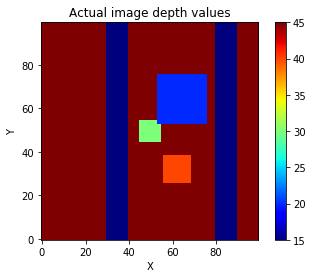

In [4]:
#show the depth wise image
%matplotlib inline
fig = plt.figure('Depth figure')
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
im = ax.imshow(p, cmap="jet", origin="lower")
fig.colorbar(im)
ax.set_title('Actual image depth values')
plt.savefig('figs/artificial_depth.png',bbox_inches='tight')

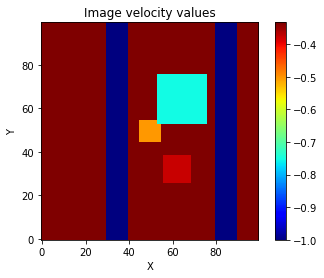

In [5]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
im = ax.imshow(v_y, cmap="jet",origin="lower")
fig.colorbar(im)
ax.set_title('Image velocity values')

# Calculating the estimated translation

The initial used algorithm is one of many, and is one of the best and most robust according to the review written by Raudies and Neumann.

In [6]:
x_lim = size[0]
y_lim = size[1]
N = 10 #number of random points in each patch
f = 15 #focal length

num_patches = 0
im_patches = np.transpose([[np.random.randint(0,10,size=N),np.random.randint(0,1,size=N)]])
for x_split in np.arange(0,x_lim,np.int(x_lim/4)):
    for y_split in np.arange(0,y_lim,np.int(y_lim/4)):
        sample_points = np.transpose([np.random.randint(x_split,x_split+np.int(x_lim/4),size=N),np.random.randint(y_split,y_split+np.int(y_lim/4),size=N)])
        im_patches = np.dstack((im_patches,sample_points))
        num_patches += 1
im_patches = im_patches[:,:,1:]

### Storing beforehand the values of the $C(T)$ matrix in memory for each candidate translation direction and each image patch

These would need to be speedily accessed and used for different values of the speed as it begins to be available to us. 

In [7]:
#delegating all of these to a file might be helpful

#don't need the following - clean when needed
def calculate_q(sample_points, omega, p):
    depths = np.transpose([p[sample_points[:,0],sample_points[:,1]]])
    inv_depths = 1/depths
    return np.vstack((inv_depths,omega))


def calculate_CT(sample_points, T): #input the presampled points
    N = np.shape(sample_points)[0]; #justincase
    A_T = np.zeros([2*N,N]) #preallocate ndarrays for storing the matrices
    B = np.zeros([2*N,3])
    
    for i in np.arange(0,N,1):
        x,y = sample_points[i,0],sample_points[i,1]
        
        #calculating A_T
        A = np.array([[-f,0,x],[0,-f,y]])
        AtimesT = np.dot(A,T)
        A_T[2*i,i], A_T[2*i+1,i] = AtimesT[0], AtimesT[1]
        
        #calculating B
        B[2*i] = np.array([(x*y)/f, -(f + (x*x)/f), y])
        B[2*i+1] = np.array([f + (y*y)/f, -(x*y)/f, -x])
    
    return np.concatenate((A_T,B),axis=1)

def calculate_projected_CT(sample_points,T):
    N = np.shape(sample_points)[0]; #justincase
    CT = calculate_CT(sample_points,T)
    CTbar, r = np.linalg.qr(CT)
    I = np.identity(2*N)
    cc = np.dot(CTbar,np.transpose(CTbar))
    return (I - cc)

def calculate_v(sample_points):
    sample_v_x, sample_v_y = v_x[sample_points[:,0],sample_points[:,1]], v_y[sample_points[:,0],sample_points[:,1]]
    v = np.vstack((sample_v_x,sample_v_y)).reshape((-1),order='F').reshape(2*N,1)
    return v

def calculate_CT_parallel_inner(params):
    idtheta, idphi,patch_id = params[0],params[1],params[2]
    theta,phi = idtheta/100,idphi/100
    x = np.cos(theta)*np.sin(phi)
    y = np.sin(theta)*np.sin(phi)
    z = np.cos(phi)
    T = np.array([[x],[y],[z]])
    sample_points = im_patches[:,:,patch_id]
    projected_CT = calculate_projected_CT(sample_points,T) #the time consumer
    np.save('ct_estimate/ct_estimate_patchid{}_idtheta{}_idphi{}.npy'.format(patch_id,idtheta,idphi),projected_CT)

    
## if time permits, try double optimisations, but remember that daemonic processes cannnot have children
## that was called calculate_CT_parallel_outer, and hence the moniker inner above

def calculate_E(params): #tentative, check use of sample_points, T or using patch_no, phi, theta
    idtheta, idphi, patch_id = params[0],params[1],params[2]    
    sample_points = im_patches[:,:,patch_id]
    projected_CT = np.load('ct_estimate/ct_estimate_patchid{}_idtheta{}_idphi{}.npy'.format(patch_id,idtheta,idphi))
    v = calculate_v(sample_points)
    E_T = (np.linalg.norm(np.dot(projected_CT,v)))**2
    return (patch_id,idtheta,idphi,E_T)
    

In [8]:
%%time
##this is to be ran only once at the beginning of the video
CPU_NUMBER = os.cpu_count()
if __name__ == '__main__':
    search_range = np.arange(0,np.int(100*np.pi),1)
    patch_id_range = range(16)
    paramlist = list(itertools.product(search_range,search_range,patch_id_range))
    pool = Pool(CPU_NUMBER)
    pool.map(calculate_CT_parallel_inner,paramlist)

CPU times: user 1.17 s, sys: 276 ms, total: 1.44 s
Wall time: 18min 5s


In [9]:
%%time

## this is to be run as the video runs - repeatedly
CPU_NUMBER = os.cpu_count()
if __name__=='__main__':
    search_range = np.arange(0,np.int(100*np.pi),1)
    patch_id_range = range(16)
    paramlist = list(itertools.product(search_range,search_range,patch_id_range))
    pool = Pool()
    res = pool.map(calculate_E,paramlist)

CPU times: user 3.92 s, sys: 1.4 s, total: 5.33 s
Wall time: 16min 5s


In [10]:
%%time
E = np.zeros((np.size(search_range),np.size(search_range)))
for item in res:
    E[item[1],item[2]] = E[item[1],item[2]] +  item[3]
    


CPU times: user 868 ms, sys: 0 ns, total: 868 ms
Wall time: 1.18 s


157 157
[[  7.96326458e-04]
 [  9.99999366e-01]
 [  7.96326711e-04]]


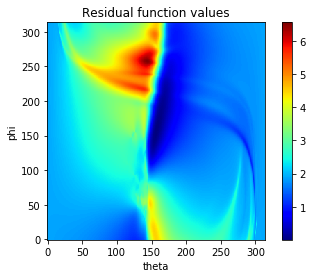

In [11]:
#plotting residual surfaces
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('theta')
ax.set_ylabel('phi')
im = ax.imshow(E, cmap="jet",origin = "lower")
fig.colorbar(im)
ax.set_title('Residual function values')
idtheta, idphi = np.unravel_index(E.argmin(), E.shape)
print(idtheta,idphi)
theta, phi = idtheta/100, idphi/100
x_final = np.cos(theta)*np.sin(phi)
y_final = np.sin(theta)*np.sin(phi)
z_final = np.cos(phi)
T_final = np.array([[x_final],[y_final],[z_final]])
print(T_final)

In [12]:
%%time
#estimating rotation given the translation

N = np.shape(sample_points)[0]; #justincase
f = 15
sum_left = np.zeros([3,3])
sum_right = np.zeros([3,1])

for time in np.arange(20,21,1):
    for i in np.arange(0,N,1):
        x,y = sample_points[i,0],sample_points[i,1]

        #calculating d
        A = np.array([[-f,0,x],[0,-f,y]])
        AtimesT = np.dot(A,T)
        d = np.array([[AtimesT[1,0]],[-AtimesT[0,0]]])
        di = d/linalg.norm(d)

        #calculating left term in omega estimate
        Bi = np.array([[(x*y)/f, -(f + (x*x)/f), y],[f + (y*y)/f, -(x*y)/f, -x]])
        sum_left += np.dot(np.transpose(Bi),np.dot(di,np.dot(np.transpose(di),Bi)))
        
        #calculating right term in omega estimate
        sample_v_x,sample_v_y = v_x[x,y],v_y[x,y]
        vi = np.array([[sample_v_x],[sample_v_y]])
        sum_right += np.dot(np.transpose(Bi),np.dot(di,np.dot(np.transpose(di),vi)))

omega = np.dot(linalg.inv(sum_left),sum_right)
print(omega)

[[ 0.]
 [ 0.]
 [ 0.]]
CPU times: user 88 ms, sys: 44 ms, total: 132 ms
Wall time: 3.25 s


In [13]:
#calculating depth
depth_mat0 = np.zeros([x_lim,y_lim])
depth_mat1 = np.zeros([x_lim,y_lim])
for x in np.arange(0,x_lim,1):
    for y in np.arange(0,y_lim,1):
        A = np.array([[-f,0,x],[0,-f,y]])
        B = np.array([[(x*y)/f, -(f + (x*x)/f), y],[f + (y*y)/f, -(x*y)/f, -x]])
        v = np.array([[v_x[x,y]],[v_y[x,y]]])
        scaled_AT = v - np.dot(B,omega)
        act_AT = np.dot(A,T)
        depth0 = (act_AT/scaled_AT)[0]
        depth1 = (act_AT/scaled_AT)[1]
        depth_mat0[x,y] = depth0
        depth_mat1[x,y] = depth1


/home/sharbat/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/home/sharbat/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


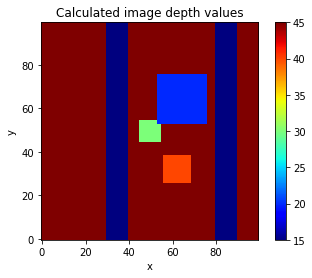

In [14]:
#plotting depth
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('x')
ax.set_ylabel('y')
im = ax.imshow(depth_mat1, cmap="jet",origin = "lower")
fig.colorbar(im)
ax.set_title('Calculated image depth values')
plt.savefig('figs/calculated_depth.png', bbox_inches='tight')
